In [1]:
!pip install wfdb --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 4.3 MB/s eta 0:00:00a 0:00:01


In [2]:
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import json


# Define dataset path
data_path = "/kaggle/input/ptb-xl-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/"

# Load SCP-ECG Statements (Error Handling Applied)
try:
    scp_df = pd.read_csv(data_path + "scp_statements.csv", encoding='utf-8')
except Exception as e:
    print("Error loading scp_statements.csv:", e)

# Load PTB-XL Metadata (Error Handling Applied)
try:
    df = pd.read_csv(data_path + "ptbxl_database.csv", encoding='utf-8')
except Exception as e:
    print("Error loading ptbxl_database.csv:", e)

# Display first few rows
# print("SCP Statements Data:\n", scp_df.head())
# print("\nPTB-XL Database Data:\n", df.head())

In [3]:
# Drop rows where diagnostic_class is missing (important for classification)
scp_df_clean = scp_df.dropna(subset=["diagnostic_class"]).copy()  # Explicit Copy

# Fill missing values for subclass and category labels
scp_df_clean.loc[:, "diagnostic_subclass"] = scp_df_clean["diagnostic_subclass"].fillna("Unknown")

# Drop columns with >70% missing data
drop_cols = ["AHA code", "aECG REFID", "CDISC Code", "DICOM Code", "form", "rhythm"]
scp_df_clean = scp_df_clean.drop(columns=drop_cols)  # No `inplace=True`

# Display cleaned dataset info
print("Cleaned SCP-ECG Statements Data:\n", scp_df_clean.info())


<class 'pandas.core.frame.DataFrame'>
Index: 44 entries, 0 to 43
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     44 non-null     object 
 1   description                    44 non-null     object 
 2   diagnostic                     44 non-null     float64
 3   diagnostic_class               44 non-null     object 
 4   diagnostic_subclass            44 non-null     object 
 5   Statement Category             44 non-null     object 
 6   SCP-ECG Statement Description  44 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.8+ KB
Cleaned SCP-ECG Statements Data:
 None


In [4]:
# Fill missing numerical values with median
num_cols = ["age", "height", "weight"]
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill missing categorical values with "Unknown"
cat_cols = ["sex", "device", "validated_by", "site"]
df[cat_cols] = df[cat_cols].fillna("Unknown")

# Convert recording_date to datetime
df["recording_date"] = pd.to_datetime(df["recording_date"], errors="coerce")

# Drop any remaining rows with critical missing data
df_clean = df.dropna()

# Display cleaned dataset info
print("Cleaned PTB-XL Database Data:\n", df_clean.info())

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   ecg_id                        0 non-null      int64         
 1   patient_id                    0 non-null      float64       
 2   age                           0 non-null      float64       
 3   sex                           0 non-null      int64         
 4   height                        0 non-null      float64       
 5   weight                        0 non-null      float64       
 6   nurse                         0 non-null      float64       
 7   site                          0 non-null      object        
 8   device                        0 non-null      object        
 9   recording_date                0 non-null      datetime64[ns]
 10  report                        0 non-null      object        
 11  scp_codes                     0 non-null      obj

In [5]:
# Check for any remaining missing values
print("Remaining Missing Values in SCP:\n", scp_df_clean.isnull().sum())
print("\nRemaining Missing Values in PTB-XL:\n", df_clean.isnull().sum())

# Save cleaned data for faster processing later
scp_df_clean.to_csv("cleaned_scp_statements.csv", index=False)
df_clean.to_csv("cleaned_ptbxl_database.csv", index=False)

print("Cleaned datasets saved successfully!")

Remaining Missing Values in SCP:
 Unnamed: 0                       0
description                      0
diagnostic                       0
diagnostic_class                 0
diagnostic_subclass              0
Statement Category               0
SCP-ECG Statement Description    0
dtype: int64

Remaining Missing Values in PTB-XL:
 ecg_id                          0
patient_id                      0
age                             0
sex                             0
height                          0
weight                          0
nurse                           0
site                            0
device                          0
recording_date                  0
report                          0
scp_codes                       0
heart_axis                      0
infarction_stadium1             0
infarction_stadium2             0
validated_by                    0
second_opinion                  0
initial_autogenerated_report    0
validated_by_human              0
baseline_drift          

In [6]:
# Add full file paths for high-resolution (500 Hz) and low-resolution (100 Hz) ECG files
df["file_path_500"] = data_path + df["filename_hr"]  # 500Hz file paths
df["file_path_100"] = data_path + df["filename_lr"]  # 100Hz file paths

# Confirm that the columns are now present
print("Available Columns in DataFrame After Fix:\n", df.columns)

Available Columns in DataFrame After Fix:
 Index(['ecg_id', 'patient_id', 'age', 'sex', 'height', 'weight', 'nurse',
       'site', 'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr',
       'file_path_500', 'file_path_100'],
      dtype='object')


In [8]:
import pandas as pd
import numpy as np
import ast  # To parse scp_codes from string to dictionary

# ✅ Load cleaned metadata
df_metadata = pd.read_csv("/kaggle/input/ptb-xl-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/ptbxl_database.csv")

# ✅ Convert 'scp_codes' column from string to dictionary
df_metadata["scp_codes"] = df_metadata["scp_codes"].apply(ast.literal_eval)

# ✅ Define MI and STTC labels based on earlier debugging
# mi_labels = ['INJAS', 'ILMI', 'INJIL', 'PMI', 'ISCAL', 'ISCLA', 'AMI', 'LMI', 'INJAL', 
#              'ALMI', 'INJIN', 'IPMI', 'ISC_', 'IMI', 'ISCAS', 'ISCIN', 'INJLA', 'ISCIL', 
#              'ISCAN', 'IPLMI', 'ASMI']

mi_labels = ['AMI', 'INJAL', 'INJAS', 'INJIL', 'INJIN', 'INJLA', 'IPMI', 'ISCAL', 'ISCAN', 'ISCAS', 
             'ISCIL', 'ISCIN', 'ISCLA', 'ILMI', 'IMI', 'IPLMI', 'LMI', 'ALMI', 'PMI', 'ASMI', 'ISC_']


# sttc_labels = ['NST_', 'STE_', 'STD_', 'STACH']
sttc_labels = ['STACH', 'STE_', 'STD_', 'NST_', 'STTC', 'STC_', 'ST_']

# ✅ Function to assign diagnostic class based on SCP codes
def assign_diagnostic_class(scp_dict):
    # Convert keys to a list
    scp_keys = list(scp_dict.keys())

    # Prioritize MI first
    if any(label in scp_keys for label in mi_labels):
        return "MI"
    # Then prioritize STTC
    elif any(label in scp_keys for label in sttc_labels):
        return "STTC"
    # Then check for NORM
    elif "NORM" in scp_keys:
        return "NORM"
    print(f"key ::{scp_keys}")
    return "OTHER"  # If nothing matches, mark as OTHER

# ✅ Apply function to dataset
df_metadata["diagnostic_class"] = df_metadata["scp_codes"].apply(assign_diagnostic_class)

# ✅ Print updated class distribution
print("\n✅ Label Distribution AFTER FIXING:")
print(df_metadata["diagnostic_class"].value_counts())


key ::['AFLT', 'ABQRS', 'AFIB']
key ::['AFLT']
key ::['AFLT', 'ABQRS']
key ::['NDT', 'SR']
key ::['AFLT']
key ::['LVH', 'SR']
key ::['LPFB', 'SR']
key ::['AFLT']
key ::['LAFB', 'SR']
key ::['IRBBB', 'RAO/RAE', 'RVH', 'SR']
key ::['NDT', 'SR']
key ::['IVCD', 'SR']
key ::['IRBBB', 'SR']
key ::['NDT', 'SR']
key ::['IRBBB', 'SR']
key ::['NDT', 'IRBBB', 'SR']
key ::['LVH', 'SR']
key ::['NDT', 'SR']
key ::['NDT', 'SR']
key ::['NDT']
key ::['NDT', 'SR']
key ::['NDT', 'SR']
key ::['LVH', 'SR']
key ::['LVH', 'SR']
key ::['1AVB', 'NDT', 'SR']
key ::['PACE']
key ::['PACE']
key ::['NDT', 'SR']
key ::['IRBBB', 'SR']
key ::['LAFB', 'SR']
key ::['IRBBB', 'SR']
key ::['CRBBB', 'LAFB', 'SR']
key ::['CLBBB', 'SR']
key ::['IRBBB', 'SR']
key ::['PACE']
key ::['LVH', '1AVB']
key ::['IRBBB', 'SR']
key ::['CRBBB', 'SR']
key ::['NDT', '1AVB', 'SR']
key ::['NDT', 'SR']
key ::['LAFB', 'ABQRS', 'SR']
key ::['RVH', 'RAO/RAE', 'IRBBB', 'ABQRS', 'SR']
key ::['LAFB', 'SR']
key ::['LAFB', 'SR']
key ::['IRBBB', 'PVC',

In [9]:
# ✅ Keep only relevant diagnostic classes
df_metadata = df_metadata[df_metadata["diagnostic_class"] != "OTHER"]

# ✅ Encode labels (Convert categories to numbers)
label_mapping = {"NORM": 0, "MI": 1, "STTC": 2}  # Assign integer labels
df_metadata["label"] = df_metadata["diagnostic_class"].map(label_mapping)

# ✅ Print updated class distribution
print("\n✅ Final Label Distribution:")
print(df_metadata["diagnostic_class"].value_counts())

# ✅ Display first few rows to confirm correct labels
print("\n✅ Sample Metadata with Labels:")
print(df_metadata[["scp_codes", "diagnostic_class", "label"]].head())



✅ Final Label Distribution:
diagnostic_class
NORM    9202
MI      6993
STTC    1302
Name: count, dtype: int64

✅ Sample Metadata with Labels:
                                  scp_codes diagnostic_class  label
0  {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}             NORM      0
1              {'NORM': 80.0, 'SBRAD': 0.0}             NORM      0
2                {'NORM': 100.0, 'SR': 0.0}             NORM      0
3                {'NORM': 100.0, 'SR': 0.0}             NORM      0
4                {'NORM': 100.0, 'SR': 0.0}             NORM      0


In [10]:
# ✅ Ensure file paths are correctly added before accessing them
df_metadata["file_path_100"] = data_path + df_metadata["filename_lr"]
df_metadata["file_path_500"] = data_path + df_metadata["filename_hr"]

# ✅ Debug: Check if columns exist
print("\n✅ Columns in df_metadata:", df_metadata.columns)

# ✅ Now print sample data
print(df_metadata[["file_path_100", "file_path_500", "label"]].head())



✅ Columns in df_metadata: Index(['ecg_id', 'patient_id', 'age', 'sex', 'height', 'weight', 'nurse',
       'site', 'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr',
       'diagnostic_class', 'label', 'file_path_100', 'file_path_500'],
      dtype='object')
                                       file_path_100  \
0  /kaggle/input/ptb-xl-dataset/ptb-xl-a-large-pu...   
1  /kaggle/input/ptb-xl-dataset/ptb-xl-a-large-pu...   
2  /kaggle/input/ptb-xl-dataset/ptb-xl-a-large-pu...   
3  /kaggle/input/ptb-xl-dataset/ptb-xl-a-large-pu...   
4  /kaggle/input/ptb-xl-dataset/ptb-xl-a-large-pu...   

                                       file_path_500  label  
0  /kaggle/input/ptb-

✅ New Dataset Size:
diagnostic_class
NORM    9202
MI      6993
STTC    1302
Name: count, dtype: int64


100%|██████████| 17497/17497 [05:28<00:00, 53.20it/s]


✅ Loaded ECG Subset Shape (100Hz): (17497, 1000, 12)
✅ Label Distribution in Processed Data:
diagnostic_class
NORM    9202
MI      6993
STTC    1302
Name: count, dtype: int64
                                       file_path_100  \
0  /kaggle/input/ptb-xl-dataset/ptb-xl-a-large-pu...   
1  /kaggle/input/ptb-xl-dataset/ptb-xl-a-large-pu...   
2  /kaggle/input/ptb-xl-dataset/ptb-xl-a-large-pu...   
3  /kaggle/input/ptb-xl-dataset/ptb-xl-a-large-pu...   
4  /kaggle/input/ptb-xl-dataset/ptb-xl-a-large-pu...   

                                       file_path_500 diagnostic_class  label  
0  /kaggle/input/ptb-xl-dataset/ptb-xl-a-large-pu...               MI      1  
1  /kaggle/input/ptb-xl-dataset/ptb-xl-a-large-pu...             NORM      0  
2  /kaggle/input/ptb-xl-dataset/ptb-xl-a-large-pu...             NORM      0  
3  /kaggle/input/ptb-xl-dataset/ptb-xl-a-large-pu...               MI      1  
4  /kaggle/input/ptb-xl-dataset/ptb-xl-a-large-pu...               MI      1  


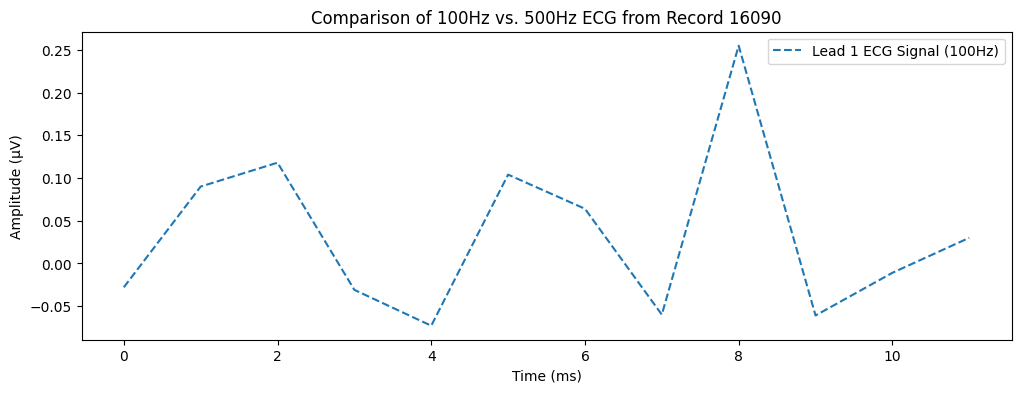

In [11]:
import wfdb
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ✅ Function to load ECG signals
def load_ecg(record_path):
    record = wfdb.rdrecord(record_path)
    return np.array(record.p_signal)  # ECG signal as a NumPy array

# ✅ Downsample the Normal Class to 7000 samples
norm_samples = df_metadata[df_metadata["diagnostic_class"] == "NORM"]
mi_samples = df_metadata[df_metadata["diagnostic_class"] == "MI"]
sttc_samples = df_metadata[df_metadata["diagnostic_class"] == "STTC"]

# ✅ Combine balanced dataset
df_balanced = pd.concat([norm_samples, mi_samples, sttc_samples])

# ✅ Shuffle the dataset to mix normal & anomalous cases
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# ✅ New dataset size after downsampling
print("✅ New Dataset Size:")
print(df_balanced["diagnostic_class"].value_counts())

# ✅ Load ECG signals (Reduce memory by only loading balanced dataset)
subset_size = len(df_balanced)  # Updated dataset size

# ✅ Load 100Hz ECGs
ecg_100Hz = np.array([load_ecg(f) for f in tqdm(df_balanced["file_path_100"][:subset_size])])

# # ✅ Load 500Hz ECGs
# ecg_500Hz = np.array([load_ecg(f) for f in tqdm(df_balanced["file_path_500"][:subset_size])])

# ✅ Print dataset shape
print("✅ Loaded ECG Subset Shape (100Hz):", ecg_100Hz.shape)
# print("✅ Loaded ECG Subset Shape (500Hz):", ecg_500Hz.shape)

# ✅ Verify Label Consistency
print("✅ Label Distribution in Processed Data:")
print(df_balanced["diagnostic_class"].value_counts())

# ✅ Debug: Check First Few Rows of Data and Labels
print(df_balanced[["file_path_100", "file_path_500", "diagnostic_class", "label"]].head())

# ✅ Plot a random ECG signal (first lead) from both datasets
sample_idx = np.random.randint(0, ecg_100Hz.shape[0])  # Random index

plt.figure(figsize=(12, 4))
plt.plot(ecg_100Hz[sample_idx, 0, :], label="Lead 1 ECG Signal (100Hz)", linestyle="dashed")
# plt.plot(ecg_500Hz[sample_idx, 0, :], label="Lead 1 ECG Signal (500Hz)", alpha=0.7)
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude (µV)")
plt.title(f"Comparison of 100Hz vs. 500Hz ECG from Record {sample_idx}")
plt.legend()
plt.show()


In [ ]:
# import wfdb
# from tqdm import tqdm
# import numpy as np
# import matplotlib.pyplot as plt

# # ✅ Function to load ECG signals
# def load_ecg(record_path):
#     record = wfdb.rdrecord(record_path)
#     return np.array(record.p_signal)  # ECG signal as a NumPy array

# # ✅ Use the filtered `df_metadata` (which contains only NORM, MI, and STTC)
# subset_size = len(df_metadata)  # Use full dataset

# # ✅ Load 100Hz ECGs
# ecg_100Hz = np.array([load_ecg(f) for f in tqdm(df_metadata["file_path_100"][:subset_size])])

# # ✅ Load 500Hz ECGs
# ecg_500Hz = np.array([load_ecg(f) for f in tqdm(df_metadata["file_path_500"][:subset_size])])

# # ✅ Print dataset shape
# print("✅ Loaded ECG Subset Shape (100Hz):", ecg_100Hz.shape)
# print("✅ Loaded ECG Subset Shape (500Hz):", ecg_500Hz.shape)

# # ✅ Verify Label Consistency
# print("✅ Label Distribution in Processed Data:")
# print(df_metadata["diagnostic_class"].value_counts())

# # ✅ Debug: Check First Few Rows of Data and Labels
# print(df_metadata[["file_path_100", "file_path_500", "diagnostic_class", "label"]].head())

# # ✅ Plot a random ECG signal (first lead) from both datasets
# sample_idx = np.random.randint(0, ecg_100Hz.shape[0])  # Random index

# plt.figure(figsize=(12, 4))
# plt.plot(ecg_100Hz[sample_idx, 0, :], label="Lead 1 ECG Signal (100Hz)", linestyle="dashed")
# plt.plot(ecg_500Hz[sample_idx, 0, :], label="Lead 1 ECG Signal (500Hz)", alpha=0.7)
# plt.xlabel("Time (ms)")
# plt.ylabel("Amplitude (µV)")
# plt.title(f"Comparison of 100Hz vs. 500Hz ECG from Record {sample_idx}")
# plt.legend()
# plt.show()


In [17]:
from sklearn.model_selection import train_test_split

# ✅ Use the filtered `df_balanced` instead of full dataset
y = df_balanced["label"].values  # Only labels of the downsampled dataset

# ✅ Split 100Hz Data
X_train_100, X_test_100, y_train_100, y_test_100 = train_test_split(
    ecg_100Hz, y, test_size=0.2, random_state=42, stratify=y
)

# # ✅ Split 500Hz Data
# X_train_500, X_test_500, y_train_500, y_test_500 = train_test_split(
#     ecg_500Hz, y, test_size=0.2, random_state=42, stratify=y
# )

# ✅ Print dataset shapes
print("✅ Data Split Complete!")
print(f"Train Shape (100Hz): {X_train_100.shape}, Test Shape: {X_test_100.shape}")
# print(f"Train Shape (500Hz): {X_train_500.shape}, Test Shape: {X_test_500.shape}")
print(f"Train Labels Shape: {y_train_100.shape}, Test Labels Shape: {y_test_100.shape}")


✅ Data Split Complete!
Train Shape (100Hz): (13997, 1000, 12), Test Shape: (3500, 1000, 12)
Train Labels Shape: (13997,), Test Labels Shape: (3500,)


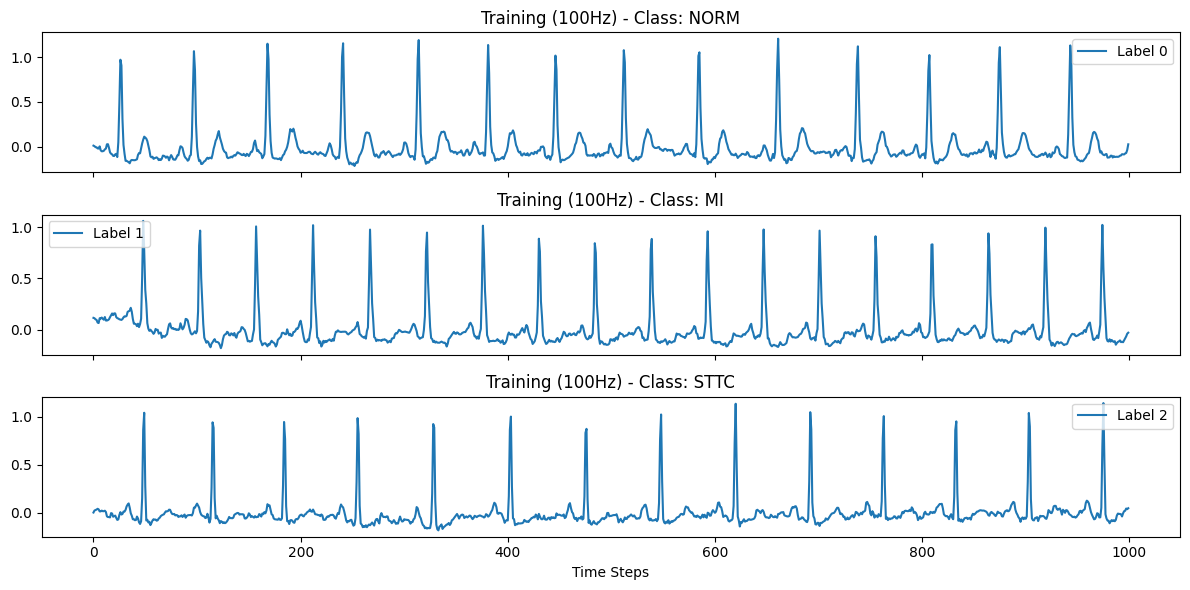

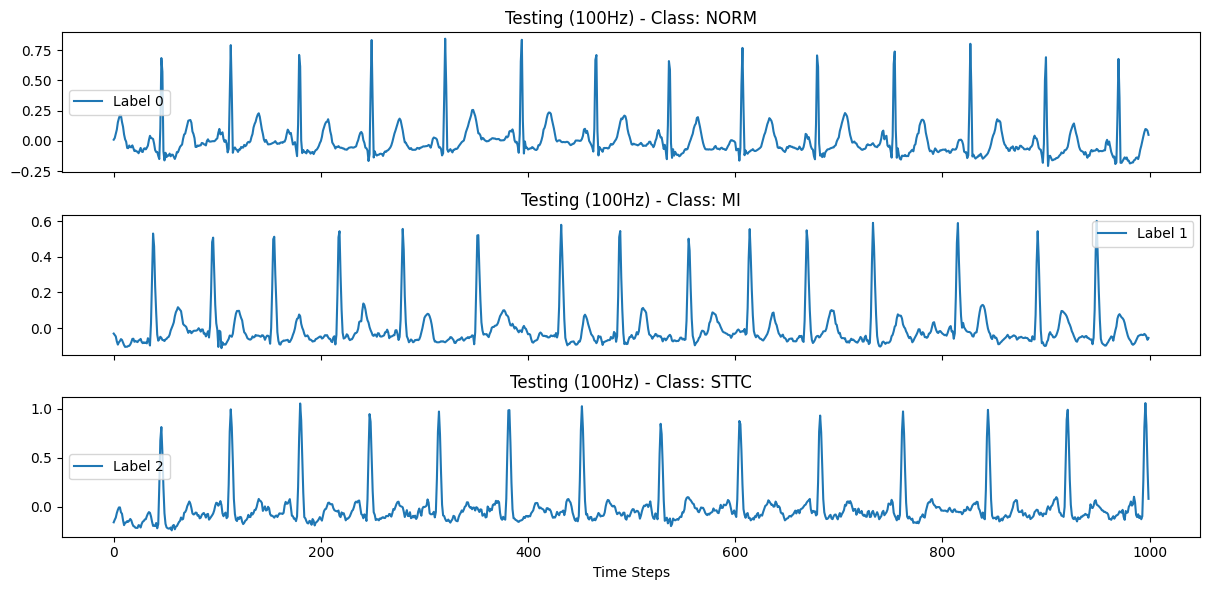

In [18]:
import matplotlib.pyplot as plt
import numpy as np

label_title =["NORM", "MI", "STTC"]

# ✅ Function to plot ECG samples
def plot_ecg_samples(X_data, y_data, dataset_name):
    unique_labels = np.unique(y_data)
    fig, axes = plt.subplots(len(unique_labels), 1, figsize=(12, 6), sharex=True)

    for i, label in enumerate(unique_labels):
        # Find the first sample from the given label
        sample_idx = np.where(y_data == label)[0][0]  # Get index of first occurrence
        
        # Plot only the first lead (Lead I)
        axes[i].plot(X_data[sample_idx, :, 0], label=f"Label {label}")
        axes[i].set_title(f"{dataset_name} - Class: {label_title[label]}")
        axes[i].legend()

    plt.xlabel("Time Steps")
    plt.tight_layout()
    plt.show()

# ✅ Show training samples
plot_ecg_samples(X_train_100, y_train_100, "Training (100Hz)")
# plot_ecg_samples(X_train_500, y_train_500, "Training (500Hz)")

# ✅ Show testing samples
plot_ecg_samples(X_test_100, y_test_100, "Testing (100Hz)")
# plot_ecg_samples(X_test_500, y_test_500, "Testing (500Hz)")


In [19]:
from tensorflow.keras.utils import to_categorical

input_shape_100 = (X_train_100.shape[1], X_train_100.shape[2])  # (1000, 12)
# input_shape_500 = (X_train_500.shape[1], X_train_500.shape[2])  # (5000, 12)

# ✅ Convert Labels to One-Hot Encoding
import tensorflow as tf
num_classes = np.max(y_train_100) + 1  # Ensure correct class count
y_train_100_encoded = tf.keras.utils.to_categorical(y_train_100, num_classes)
y_test_100_encoded = tf.keras.utils.to_categorical(y_test_100, num_classes)


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

# ✅ Function to Plot Training Loss & Accuracy
def plot_training_history(history, title="Model Performance"):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # ✅ Plot Loss
    axes[0].plot(history.history['loss'], label='Train Loss', color='blue')
    axes[0].plot(history.history['val_loss'], label='Validation Loss', color='red')
    axes[0].set_title(f'{title} - Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # ✅ Plot Accuracy
    axes[1].plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    axes[1].set_title(f'{title} - Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    return plt


# ✅ Plot Performance for 500Hz Model
# plot_training_history(history_500Hz, title="CNN+LSTM (500Hz)")


# ✅ Function to Compute & Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    return plt

# ✅ Predict on Test Data
# y_pred_100Hz = np.argmax(model_100Hz.predict(X_test_100), axis=1)
# y_pred_500Hz = np.argmax(model_500Hz.predict(X_test_500), axis=1)


# ✅ Confusion Matrix for 500Hz
# plot_confusion_matrix(y_test_500, y_pred_500Hz, classes=class_names, title="Confusion Matrix - 500Hz")


# ✅ Function to Display Classification Report
def display_classification_report(y_true, y_pred, title="Classification Report"):
    print(f"\n🔹 {title}\n")
    print(classification_report(y_true, y_pred, target_names=class_names))


# ✅ Print Classification Report for 500Hz
# display_classification_report(y_test_500, y_pred_500Hz, title="Classification Report - 500Hz")


# ✅ Function to Plot ROC Curve & AUC Score
def plot_roc_curve(y_true, y_probs, title="ROC Curve"):
    plt.figure(figsize=(8, 6))

    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true == i, y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Random guess line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    return plt



# ✅ ROC Curve for 500Hz
# y_probs_500Hz = model_500Hz.predict(X_test_500)
# plot_roc_curve(y_test_500, y_probs_500Hz, title="ROC Curve - 500Hz")


# ✅ Function to Plot Precision-Recall Curve
def plot_precision_recall_curve(y_true, y_probs, title="Precision-Recall Curve"):
    plt.figure(figsize=(8, 6))

    for i, class_name in enumerate(class_names):
        precision, recall, _ = precision_recall_curve(y_true == i, y_probs[:, i])
        plt.plot(recall, precision, label=f"{class_name}")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend(loc="upper right")
    return plt


# ✅ Precision-Recall Curve for 500Hz
# plot_precision_recall_curve(y_test_500, y_probs_500Hz, title="Precision-Recall Curve - 500Hz")

print("✅ Performance Evaluation Complete!")


✅ Performance Evaluation Complete!


# Model Configs

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, LSTM, Dense
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# ✅ Define Model
def build_cnn_lstm_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # ✅ CNN Feature Extractor
    x = Conv1D(32, kernel_size=5, strides=1, activation="relu", padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Conv1D(64, kernel_size=5, strides=1, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Conv1D(128, kernel_size=5, strides=1, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # ✅ LSTM Layers
    x = LSTM(128, return_sequences=True)(x)
    x = LSTM(64, return_sequences=False)(x)

    # ✅ Fully Connected Layers
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation="softmax")(x)  # Softmax for multi-class classification

    model = Model(inputs, outputs)
    return model

# ✅ Define Optimized CNN-GRU Model
def build_optimized_cnn_gru_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # ✅ CNN Feature Extractor
    x = Conv1D(64, kernel_size=5, strides=1, activation="relu", padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Conv1D(128, kernel_size=3, strides=1, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # ✅ GRU Layer (Replacing LSTM for Speed)
    x = GRU(128, return_sequences=False, dropout=0.1)(x)

    # ✅ Fully Connected Layer
    x = Dense(64, activation="relu", kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.3)(x)

    # ✅ Output Layer
    outputs = Dense(num_classes, activation="softmax")(x)  # Softmax for multi-class classification

    model = Model(inputs, outputs)
    return model

# ✅ Define BiLSTM Model
def build_cnn_bilstm_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # ✅ CNN Feature Extractor
    x = Conv1D(32, kernel_size=5, strides=1, activation="relu", padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Conv1D(64, kernel_size=5, strides=1, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Conv1D(128, kernel_size=5, strides=1, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # ✅ BiLSTM Layer (Bidirectional LSTM)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Bidirectional(LSTM(64, return_sequences=False))(x)

    # ✅ Fully Connected Layers
    x = Dense(64, activation="relu", kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.3)(x)

    # ✅ Output Layer (Softmax for Multi-Class)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    return model


In [21]:
import tensorflow as tf
from tensorflow.keras import backend as K

alpha=[0.25, 0.3, 0.50]
# ✅ Custom Categorical Focal Loss
def categorical_focal_loss(alpha=[0.25, 0.25, 0.50], gamma=2.0):
    def focal_loss(y_true, y_pred):
        epsilon = K.epsilon()  # Small value to prevent log(0)
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)  # Prevent NaNs
        cross_entropy = -y_true * K.log(y_pred)  # Standard categorical cross-entropy

        alpha_tensor = K.constant(alpha, dtype=K.floatx())  # Convert to tensor
        weight = alpha_tensor * K.pow(1 - y_pred, gamma)  # Apply Focal Weighting

        focal_loss = weight * cross_entropy  # Compute loss
        return K.sum(focal_loss, axis=1)  # Sum loss per sample

    return focal_loss

# CNN_LSTM

In [ ]:


# ✅ Set Input Shape & Number of Classes
# input_shape = (1000, 12)  # (Time Steps, Channels)
# num_classes = len(set(y_train_100))  # Dynamically get number of classes

# input_shape_100 = (X_train_100.shape[1], X_train_100.shape[2])  # (1000, 12)
# input_shape_500 = (X_train_500.shape[1], X_train_500.shape[2])  # (5000, 12)

# ✅ Instantiate Model
# model = build_cnn_lstm_model(input_shape, num_classes)
model_100Hz = build_cnn_lstm_model(input_shape_100, num_classes)
# model_500Hz = build_optimized_cnn_lstm_model(input_shape_500, num_classes)

# ✅ Cosine Decay Learning Rate Scheduler
initial_learning_rate = 0.001
lr_schedule = CosineDecay(initial_learning_rate, decay_steps=30, alpha=0.1)

# ✅ Compile Model with Adam Optimizer & Learning Rate Schedule
model_100Hz.compile(optimizer=Adam(learning_rate=initial_learning_rate), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
# model_500Hz.compile(optimizer=Adam(learning_rate=initial_learning_rate), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# ✅ Callbacks for Early Stopping & Reduce LR on Plateau
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)


In [ ]:
# ✅ Train Model on 100Hz Data
history_100Hz = model_100Hz.fit(
    X_train_100, y_train_100,
    validation_split=0.1,  # 10% of training data used for validation
    epochs=50,  # Allow up to 50 epochs, early stopping will stop training if needed
    batch_size=32,  # Smaller batch size for better generalization
    verbose=1,
    callbacks=[early_stopping, reduce_lr]  # Integrated Callbacks
)

# Save training history
with open("history_100Hz.json", "w") as f:
    json.dump(history_100Hz.history, f)
    
model_100Hz.save('model_100hz_lstm.h5')

In [ ]:

# ✅ Plot Performance for 100Hz Model
his_plot = plot_training_history(history_100Hz, title="CNN+LSTM (100Hz)")
his_plot.savefig('lstm_100hz_his.png', dpi=300)
his_plot.show()


# ✅ Get Class Names
class_names = ["NORM", "MI", "STTC"]

y_pred_100Hz = np.argmax(model_100Hz.predict(X_test_100), axis=1)

# ✅ Confusion Matrix for 100Hz
conf_matrix = plot_confusion_matrix(y_test_100, y_pred_100Hz, classes=class_names, title="Confusion Matrix - 100Hz")
conf_matrix.savefig('lstm_100hz_matrix.png', dpi=300)

# ✅ Print Classification Report for 100Hz
display_classification_report(y_test_100, y_pred_100Hz, title="Classification Report - 100Hz")

# ✅ ROC Curve for 100Hz
y_probs_100Hz = model_100Hz.predict(X_test_100)  # Get probabilities
roc_plot = plot_roc_curve(y_test_100, y_probs_100Hz, title="ROC Curve - 100Hz")
roc_plot.savefig('lstm_100hz_roc_plot.png', dpi=300)
roc_plot.show()

# ✅ Precision-Recall Curve for 100Hz
plot_precision = plot_precision_recall_curve(y_test_100, y_probs_100Hz, title="Precision-Recall Curve - 100Hz")
plot_precision.savefig('lstm_100hz_precision.png', dpi=300)
plot_precision.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


# ✅ Compile Model
def compile_model(model):
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# ✅ Learning Rate Scheduler & Early Stopping
def get_callbacks():
    return [
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    ]

# ✅ Model Training
def train_model(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
    callbacks = get_callbacks()
    history = model.fit(
        X_train, y_train,
        validation_split=0.1,  # 10% of training data used for validation
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    return history

gru_model = build_optimized_cnn_gru_model(input_shape_100, num_classes)
compile_model(gru_model)
gru_history = train_model(gru_model, X_train_100, y_train_100_encoded, 50, 32);

# Save training history
with open("gru_100hz_history.json", "w") as f:
    json.dump(gru_history.history, f)

gru_model.save('gru_model.h5')

In [ ]:

# ✅ Plot Performance for 100Hz Model
his_plot = plot_training_history(gru_history, title="CNN+GRU (100Hz)")
his_plot.savefig('gru_100hz_his.png', dpi=300)
his_plot.show()


# ✅ Get Class Names
class_names = ["NORM", "MI", "STTC"]

y_pred_100Hz = np.argmax(gru_model.predict(X_test_100), axis=1)

# ✅ Confusion Matrix for 100Hz
conf_matrix = plot_confusion_matrix(y_test_100, y_pred_100Hz, classes=class_names, title="Confusion Matrix - 100Hz")
conf_matrix.savefig('gru_100hz_matrix.png', dpi=300)

# ✅ Print Classification Report for 100Hz
display_classification_report(y_test_100, y_pred_100Hz, title="Classification Report - CNN-GRU - 100Hz")

# ✅ ROC Curve for 100Hz
y_probs_100Hz = gru_model.predict(X_test_100)  # Get probabilities
roc_plot = plot_roc_curve(y_test_100, y_probs_100Hz, title="ROC Curve - 100Hz")
roc_plot.savefig('gru_100hz_roc_plot.png', dpi=300)
roc_plot.show()

# ✅ Precision-Recall Curve for 100Hz
plot_precision = plot_precision_recall_curve(y_test_100, y_probs_100Hz, title="Precision-Recall Curve - 100Hz")
plot_precision.savefig('gru_100hz_precision.png', dpi=300)
plot_precision.show()


# Bi-Directional LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, Bidirectional, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


# ✅ Compile Model
def compile_model(model):
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

num_classes = np.max(y_train_100) + 1 
# ✅ Build & Compile BiLSTM Model
bilstm_model = build_cnn_bilstm_model(input_shape_100, num_classes)
compile_model(bilstm_model)




In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

# ✅ Define Callbacks
def get_callbacks():
    return [
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    ]

# ✅ Train Model
def train_model_bilstm(bi_model, X_train, y_train, epochs=50, batch_size=32):
    callbacks = get_callbacks()
    print("Starting training...")
    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)
    # Train Model
    history = bi_model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    # Ensure history is not None
    if history is None:
        raise ValueError("Training failed, check input data.")

    return history

# ✅ Train BiLSTM Model
bilstm_history = train_model_bilstm(bilstm_model, X_train_100, y_train_100_encoded, epochs=50, batch_size=16)

with open("bilstm_history.json", "w") as f:
    json.dump(bilstm_history.history, f)

bilstm_model.save('bi_directional_lstm.h5')


In [ ]:

# ✅ Plot Performance for 100Hz Model
his_plot = plot_training_history(bilstm_history, title="CNN+BiLSTM (100Hz)")
his_plot.savefig('bi_lstm_100hz_his.png', dpi=300)
his_plot.show()


# ✅ Get Class Names
class_names = ["NORM", "MI", "STTC"]

y_pred_100Hz = np.argmax(bilstm_model.predict(X_test_100), axis=1)

# ✅ Confusion Matrix for 100Hz
conf_matrix = plot_confusion_matrix(y_test_100, y_pred_100Hz, classes=class_names, title="Confusion Matrix - 100Hz")
conf_matrix.savefig('bilstm_100hz_matrix.png', dpi=300)

# ✅ Print Classification Report for 100Hz
display_classification_report(y_test_100, y_pred_100Hz, title="Classification Report - CNN-Bi-LSTM - 100Hz")

# ✅ ROC Curve for 100Hz
y_probs_100Hz = bilstm_model.predict(X_test_100)  # Get probabilities
roc_plot = plot_roc_curve(y_test_100, y_probs_100Hz, title="ROC Curve - 100Hz")
roc_plot.savefig('bli_lsttm_100hz_roc_plot.png', dpi=300)
roc_plot.show()

# ✅ Precision-Recall Curve for 100Hz
plot_precision = plot_precision_recall_curve(y_test_100, y_probs_100Hz, title="Precision-Recall Curve - 100Hz")
plot_precision.savefig('bi_lstm_100hz_precision.png', dpi=300)
plot_precision.show()


# Categorical Focal Loss Starts

In [ ]:
alpha = [0.25, 0.3, 0.75]

In [ ]:
# ✅ Compile Model
def compile_model(model):
    optimizer = Adam(learning_rate=0.001)
    model.compile( loss=categorical_focal_loss(alpha=alpha, gamma=2.0), optimizer=optimizer, metrics=["accuracy"])

num_classes = np.max(y_train_100) + 1 
# ✅ Build & Compile BiLSTM Model
bilstm_model = build_cnn_bilstm_model(input_shape_100, num_classes)
compile_model(bilstm_model)

# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

# ✅ Define Callbacks
def get_callbacks():
    return [
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    ]

# ✅ Train Model
def train_model_bilstm(bi_model, X_train, y_train, epochs=50, batch_size=32):
    callbacks = get_callbacks()
    print("Starting training...")
    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)
    # Train Model
    history = bi_model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    # Ensure history is not None
    if history is None:
        raise ValueError("Training failed, check input data.")

    return history


# ✅ Train BiLSTM Model
bilstm_history = train_model_bilstm(bilstm_model, X_train_100, y_train_100_encoded, epochs=50, batch_size=16)
# Save training history
with open("bistm_history_100_focalloss.json", "w") as f:
    json.dump(bilstm_history.history, f)

bilstm_model.save('biLSTM_focal_loss.h5')

In [ ]:

# ✅ Plot Performance for 100Hz Model
his_plot = plot_training_history(bilstm_history, title="CNN+BiLSTM (100Hz)")
his_plot.savefig('bi_lstm_100hz_his.png', dpi=300)
his_plot.show()


# ✅ Get Class Names
class_names = ["NORM", "MI", "STTC"]

y_pred_100Hz = np.argmax(bilstm_model.predict(X_test_100), axis=1)

# ✅ Confusion Matrix for 100Hz
conf_matrix = plot_confusion_matrix(y_test_100, y_pred_100Hz, classes=class_names, title="Confusion Matrix - 100Hz")
conf_matrix.savefig('bilstm_100hz_matrix.png', dpi=300)

# ✅ Print Classification Report for 100Hz
display_classification_report(y_test_100, y_pred_100Hz, title="Classification Report - CNN-Bi-LSTM - 100Hz")

# ✅ ROC Curve for 100Hz
y_probs_100Hz = bilstm_model.predict(X_test_100)  # Get probabilities
roc_plot = plot_roc_curve(y_test_100, y_probs_100Hz, title="ROC Curve - 100Hz")
roc_plot.savefig('bli_lsttm_100hz_roc_plot.png', dpi=300)
roc_plot.show()

# ✅ Precision-Recall Curve for 100Hz
plot_precision = plot_precision_recall_curve(y_test_100, y_probs_100Hz, title="Precision-Recall Curve - 100Hz")
plot_precision.savefig('bi_lstm_100hz_precision.png', dpi=300)
plot_precision.show()


# Categorical Focal Loss CNN_LSTM

In [ ]:
from keras.layers import GRU

model_100Hz = build_cnn_lstm_model(input_shape_100, num_classes)
# model_500Hz = build_optimized_cnn_lstm_model(input_shape_500, num_classes)

# ✅ Cosine Decay Learning Rate Scheduler
initial_learning_rate = 0.001
lr_schedule = CosineDecay(initial_learning_rate, decay_steps=30, alpha=0.1)

# ✅ Compile Model with Adam Optimizer & Learning Rate Schedule
# ✅ Compile Model with Focal Loss
model_100Hz.compile(optimizer=Adam(learning_rate=initial_learning_rate), 
                    loss=categorical_focal_loss(alpha=alpha, gamma=2.0), 
                    metrics=["accuracy"])
# model_500Hz.compile(optimizer=Adam(learning_rate=initial_learning_rate), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# ✅ Callbacks for Early Stopping & Reduce LR on Plateau
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)


In [ ]:
# ✅ Train Model on 100Hz Data
history_100Hz = model_100Hz.fit(
    X_train_100, y_train_100_encoded,
    validation_split=0.1,  # 10% of training data used for validation
    epochs=50,  # Allow up to 50 epochs, early stopping will stop training if needed
    batch_size=32,  # Smaller batch size for better generalization
    verbose=1,
    callbacks=[early_stopping, reduce_lr]  # Integrated Callbacks
)
# Save training history
with open("lstm_fcl_history_100Hz.json", "w") as f:
    json.dump(history_100Hz.history, f)
    
model_100Hz.save('100hz_model_focal_loss.h5')

In [ ]:

# ✅ Plot Performance for 100Hz Model
his_plot = plot_training_history(history_100Hz, title="CNN+LSTM (100Hz)")
his_plot.savefig('lstm_fcl_100hz_his.png', dpi=300)
his_plot.show()


# ✅ Get Class Names
class_names = ["NORM", "MI", "STTC"]

y_pred_100Hz = np.argmax(model_100Hz.predict(X_test_100), axis=1)

# ✅ Confusion Matrix for 100Hz
conf_matrix = plot_confusion_matrix(y_test_100, y_pred_100Hz, classes=class_names, title="Confusion Matrix - 100Hz")
conf_matrix.savefig('lstm_fcl_100hz_matrix.png', dpi=300)

# ✅ Print Classification Report for 100Hz
display_classification_report(y_test_100, y_pred_100Hz, title="Classification Report - 100Hz")

# ✅ ROC Curve for 100Hz
y_probs_100Hz = model_100Hz.predict(X_test_100)  # Get probabilities
roc_plot = plot_roc_curve(y_test_100, y_probs_100Hz, title="ROC Curve - 100Hz")
roc_plot.savefig('lstm_fcl_100hz_roc_plot.png', dpi=300)
roc_plot.show()

# ✅ Precision-Recall Curve for 100Hz
plot_precision = plot_precision_recall_curve(y_test_100, y_probs_100Hz, title="Precision-Recall Curve - 100Hz")
plot_precision.savefig('lstm_fcl_100hz_precision.png', dpi=300)
plot_precision.show()


# GRU Categorical Focal Loss

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, GRU, Dense

input_shape_100 = (X_train_100.shape[1], X_train_100.shape[2])  # (1000, 12)

# ✅ Compile Model
def compile_model(model):
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss=categorical_focal_loss(alpha=[0.25,0.25,0.75], gamma=2.0), optimizer=optimizer, metrics=["accuracy"])

# ✅ Learning Rate Scheduler & Early Stopping
def get_callbacks():
    return [
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    ]

# ✅ Model Training
def train_model(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
    callbacks = get_callbacks()
    history = model.fit(
        X_train, y_train,
        validation_split=0.1,  # 10% of training data used for validation
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    return history

gru_model = build_optimized_cnn_gru_model(input_shape_100, num_classes)
compile_model(gru_model)
gru_history = train_model(gru_model, X_train_100, y_train_100_encoded, 50, 32);
# Save training history
with open("gru_fcl_history_100Hz.json", "w") as f:
    json.dump(gru_history.history, f)
    
gru_model.save('gru_focal_loss.h5')



In [ ]:

# ✅ Plot Performance for 100Hz Model
his_plot = plot_training_history(gru_history, title="CNN+GRU (100Hz)")
his_plot.savefig('gru_fcl_100hz_his.png', dpi=300)
his_plot.show()


# ✅ Get Class Names
class_names = ["NORM", "MI", "STTC"]

y_pred_100Hz = np.argmax(gru_model.predict(X_test_100), axis=1)

# ✅ Confusion Matrix for 100Hz
conf_matrix = plot_confusion_matrix(y_test_100, y_pred_100Hz, classes=class_names, title="Confusion Matrix - 100Hz")
conf_matrix.savefig('gru_fcl_100hz_matrix.png', dpi=300)

# ✅ Print Classification Report for 100Hz
display_classification_report(y_test_100, y_pred_100Hz, title="Classification Report - CNN-GRU - 100Hz")

# ✅ ROC Curve for 100Hz
y_probs_100Hz = gru_model.predict(X_test_100)  # Get probabilities
roc_plot = plot_roc_curve(y_test_100, y_probs_100Hz, title="ROC Curve - 100Hz")
roc_plot.savefig('gru_fcl_100hz_roc_plot.png', dpi=300)
roc_plot.show()

# ✅ Precision-Recall Curve for 100Hz
plot_precision = plot_precision_recall_curve(y_test_100, y_probs_100Hz, title="Precision-Recall Curve - 100Hz")
plot_precision.savefig('gru_fcl_100hz_precision.png', dpi=300)
plot_precision.show()


# Bi-LSTM CFL

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, Bidirectional, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


# ✅ Compile Model
def compile_model(model):
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

num_classes = np.max(y_train_100) + 1 
# ✅ Build & Compile BiLSTM Model
bilstm_model = build_cnn_bilstm_model(input_shape_100, num_classes)
compile_model(bilstm_model)


# Ensamble

In [22]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

# ✅ Re-Define Categorical Focal Loss
def categorical_focal_loss(alpha=[0.25, 0.3, 0.75], gamma=2.0):
    def focal_loss(y_true, y_pred):
        epsilon = K.epsilon()  # Prevent log(0)
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)  # Prevent NaNs
        cross_entropy = -y_true * K.log(y_pred)  # Standard Cross Entropy
        weight = alpha * K.pow(1 - y_pred, gamma)  # Focal loss weighting
        focal_loss = weight * cross_entropy
        return K.sum(focal_loss, axis=1)  # Sum per sample
    return focal_loss  # Return function

# ✅ Create Custom Objects Dictionary
custom_objects = {"categorical_focal_loss": categorical_focal_loss()}  # Ensure function is passed

# ✅ Load Models (No Custom Loss Required)
cnn_lstm = load_model('/kaggle/input/cnnlstm_100hz_v1/keras/default/1/model_100hz_lstm.h5')
gru_lstm = load_model('/kaggle/input/gru_100hz/keras/default/1/gru_model.h5')
bi_directional = load_model('/kaggle/input/bi_directional_lstm/keras/default/1/bi_directional_lstm.h5')

# ✅ Load Models with Custom Loss (Disable Compilation Initially)
gru_lstm_fcl = load_model(
    '/kaggle/input/gru_focal_loss/keras/default/1/gru_focal_loss.h5',
    custom_objects=custom_objects,
    compile=False  # Load without compiling
)
bi_directional_fcl = load_model(
    '/kaggle/input/bi_directional_fcl/keras/default/1/biLSTM_focal_loss.h5',
    custom_objects=custom_objects,
    compile=False
)

# ✅ Manually Compile Models with Focal Loss
gru_lstm_fcl.compile(
    optimizer="adam",
    loss=categorical_focal_loss(alpha=[0.25, 0.3, 0.75], gamma=2.0),
    metrics=["accuracy"]
)

bi_directional_fcl.compile(
    optimizer="adam",
    loss=categorical_focal_loss(alpha=[0.25, 0.3, 0.75], gamma=2.0),
    metrics=["accuracy"]
)

# ✅ Confirm Successful Loading
print("✅ All models loaded successfully!")


✅ All models loaded successfully!


In [24]:
# ✅ Load Models
from sklearn.metrics import accuracy_score

models = {
    "cnn_lstm": cnn_lstm,
    "gru_lstm": gru_lstm,
    "gru_lstm_fcl": gru_lstm_fcl,
    "bi_lstm": bi_directional,
    "bi_lstm_fcl": bi_directional_fcl,
    # "cnn_lstm_fcl": load_model("/kaggle/input/cnnlstm_fcl/keras/default/1/cnnlstm_focal_loss.h5", custom_objects=custom_objects),  # If you have this
}

# ✅ Prepare test data
X_test = X_test_100
y_true = np.argmax(y_test_100_encoded, axis=1)  # Convert one-hot to class labels

# ✅ Evaluate Each Model
for name, model in models.items():
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    acc = accuracy_score(y_true, y_pred)
    print(f"{name} Accuracy: {acc * 100:.2f}%")

110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step
cnn_lstm Accuracy: 86.74%
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
gru_lstm Accuracy: 87.34%
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
gru_lstm_fcl Accuracy: 83.09%
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step
bi_lstm Accuracy: 85.83%
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step
bi_lstm_fcl Accuracy: 84.83%


In [26]:
from sklearn.linear_model import LogisticRegression

# ✅ Load test data
# Assuming X_test_100 and y_test_100_encoded are preprocessed test inputs and labels
X_test = X_test_100
y_test = np.argmax(y_test_100_encoded, axis=1)  # Convert one-hot to categorical labels

# ✅ Get predictions from each model
pred_cnn_lstm = cnn_lstm.predict(X_test)
pred_gru_lstm = gru_lstm.predict(X_test)
pred_gru_lstm_fcl = gru_lstm_fcl.predict(X_test)
pred_bi_directional = bi_directional.predict(X_test)
pred_bi_directional_fcl = bi_directional_fcl.predict(X_test)

# ✅ Stack predictions as features for meta-classifier
stacked_predictions = np.hstack([
    pred_cnn_lstm, 
    pred_gru_lstm, 
    pred_gru_lstm_fcl, 
    pred_bi_directional, 
    pred_bi_directional_fcl
])  # Shape: (num_samples, num_classes * 5)

# ✅ Train meta-classifier (Logistic Regression)
meta_classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
meta_classifier.fit(stacked_predictions, y_test)

# ✅ Predict using meta-classifier
final_predictions = meta_classifier.predict(stacked_predictions)

# ✅ Evaluate Performance
accuracy = accuracy_score(y_test, final_predictions)
print(f"Stacked Model Accuracy: {accuracy:.4f}")

print("Classification Report:\n", classification_report(y_test, final_predictions))



110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step
Stacked Model Accuracy: 0.8743
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.92      1841
           1       0.87      0.86      0.87      1399
           2       0.58      0.43      0.49       260

    accuracy                           0.87      3500
   macro avg       0.79      0.75      0.76      3500
weighted avg       0.87      0.87      0.87      3500



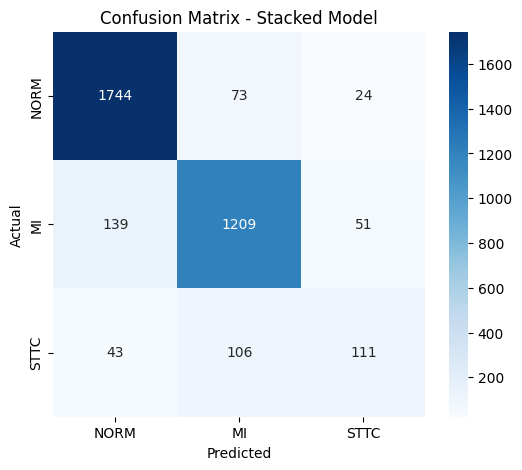

Classification Report:
               precision    recall  f1-score   support

        NORM       0.91      0.95      0.93      1841
          MI       0.87      0.86      0.87      1399
        STTC       0.60      0.43      0.50       260

    accuracy                           0.88      3500
   macro avg       0.79      0.75      0.76      3500
weighted avg       0.87      0.88      0.87      3500



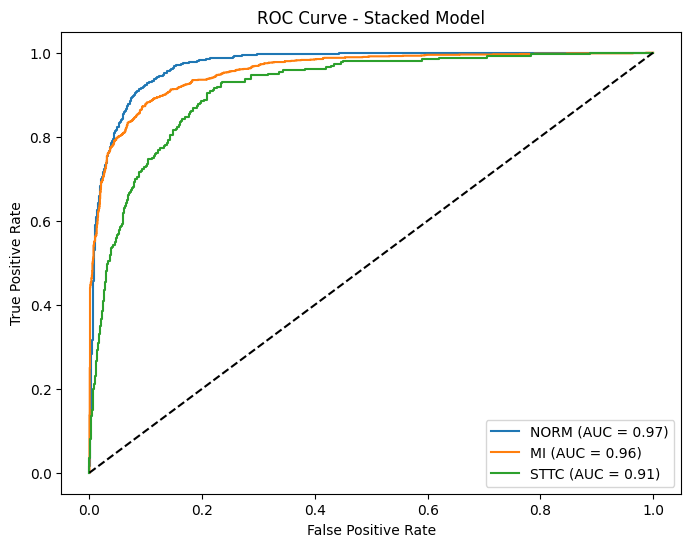

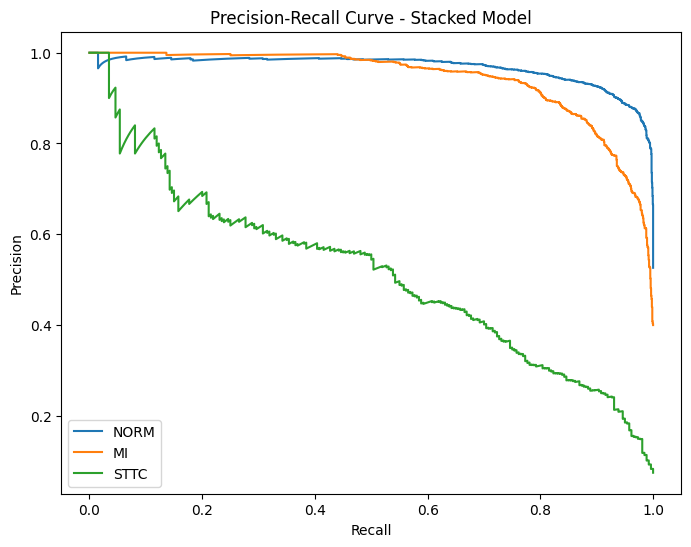

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import seaborn as sns

# ✅ Compute confusion matrix
cm = confusion_matrix(y_test, final_predictions)
labels = ["NORM", "MI", "STTC"]  # Assuming these are the class labels

# ✅ Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Stacked Model")
plt.savefig("emsamble_conf_matrix.png", dpi=300)
plt.show()

# ✅ Classification Report
print("Classification Report:\n", classification_report(y_test, final_predictions, target_names=labels))

# ✅ Compute ROC Curves and AUC for each class
plt.figure(figsize=(8, 6))

for i in range(len(labels)):  
    fpr, tpr, _ = roc_curve(y_test == i, stacked_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{labels[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Stacked Model")
plt.legend(loc="lower right")
plt.savefig("emsamble_roc.png", dpi=300)
plt.show()

# ✅ Compute Precision-Recall Curve
plt.figure(figsize=(8, 6))

for i in range(len(labels)):  
    precision, recall, _ = precision_recall_curve(y_test == i, stacked_predictions[:, i])
    plt.plot(recall, precision, label=f"{labels[i]}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Stacked Model")
plt.legend(loc="lower left")
plt.savefig("emsamble_precision.png", dpi=300)
plt.show()
